<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Checks" data-toc-modified-id="Checks-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Checks</a></span></li></ul></li><li><span><a href="#NMDS-of-tree" data-toc-modified-id="NMDS-of-tree-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NMDS of tree</a></span></li><li><span><a href="#Abundance-transform" data-toc-modified-id="Abundance-transform-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Abundance transform</a></span></li><li><span><a href="#MPD/MNTD" data-toc-modified-id="MPD/MNTD-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>MPD/MNTD</a></span></li><li><span><a href="#Matrix-of-tax-labels" data-toc-modified-id="Matrix-of-tax-labels-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Matrix of tax labels</a></span></li><li><span><a href="#Creating-'images'" data-toc-modified-id="Creating-'images'-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Creating 'images'</a></span></li><li><span><a href="#Creating-images-with-abund-weighted-patristic-distances" data-toc-modified-id="Creating-images-with-abund-weighted-patristic-distances-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Creating images with abund-weighted patristic distances</a></span><ul class="toc-item"><li><span><a href="#Running-on-westernized/non-westernized" data-toc-modified-id="Running-on-westernized/non-westernized-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Running on westernized/non-westernized</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-10.1.1"><span class="toc-item-num">10.1.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li></ul></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Sandbox</a></span></li></ul></div>

# Goal

* Convert metagenomes to "images"
  * 1 image per sample
* x,y axes
  * rank order of nmds/pcoa on microbiome tree
* RGB
  * R = relative abundances
  * G = phylomeasures::MNTD, weighted abundances
  * B = phylomeasures::MPD, weighted abundances
* The images will be used for DL of microbiomes

# Var

In [1]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/ML/'

# bracken counts
brk_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/bracken_filt.qs'

# metadata
## filtered
metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_f.tsv')

# trees
## GTDB genome phylogeny
phy_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/phylogeny/ar122-bac120_r89_1per-GTDB-Spec_gte50comp-lt5cont_rn.nwk'
## Trait 
phy_trt_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/predictions_flat_majority-votes_combined_jaccard_rn.nwk'
## COG content
phy_cog_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-COG_bray.nwk'
phy_cogcat_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-COGcat_bray.nwk'
## pfam content
phy_pfam_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-pfam_bray.nwk'
phy_pfamcat_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-pfamGrp_bray.nwk'

# params
threads = 8

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(vegan)
#library(PhyloMeasures)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘tidytable’


The following object is masked from ‘package:stats’:

    dt


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [3]:
make_dir(work_dir)
setDTthreads(threads)
df.dims()

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/ML/ 


# Load

In [43]:
# all 
meta = fread(metadata_file, sep='\t', check.names=TRUE) %>%
    mutate.(Sample = gsub('-', '.', Sample)) %>%
    filter.(number_reads >= 5e5) %>%
    select.(Sample, dataset_name, subjectID, study_condition, 
              disease, age, gender, BMI, westernized)

meta %>% unique_n('Samples', Sample)
meta

No. of unique Samples: 3582 


Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
MV_FEM1_t1Q14,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
MV_FEM2_t1Q14,AsnicarF_2017,MV_FEM2,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
CCIS82944710ST.20.0,ZellerG_2014,FR-730,control,healthy,38,female,22,TRUE
CCIS93040568ST.20.0,ZellerG_2014,FR-682,control,healthy,65,male,30,TRUE


In [44]:
# Bracken count table
brk = qs::qread(brk_file, nthreads=threads) %>%
    mutate.(name = gsub(' ', '_', name))
brk %>% unique_n('Species', name)
brk 

No. of unique Species: 3550 


dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Caecibacter_massiliensis,108259,S,Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Megasphaeraceae,Caecibacter,Caecibacter massiliensis,halbarad.11.0.0,0
CosteaPI_2017,s__UBA1777_sp002350825,178550,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,UBA1777,UBA1777 sp002350825,halbarad.11.0.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Serratia_grimesii,121568,S,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Serratia,Serratia grimesii,SZAXPI017592.142,0
YuJ_2015,s__Bacteroides_A_sp002161565,119189,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_A,Bacteroides_A sp002161565,SZAXPI017592.142,0


In [45]:
# abundance filtering
brk = brk %>%
    mutate.(mean_abund = mean(Abundance), .by=c(name)) %>%
    filter.(mean_abund > 0.0005) 
brk %>% unique_n('Species', name)
brk

No. of unique Species: 335 


dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance,mean_abund
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CosteaPI_2017,s__Eubacterium_G_ventriosum,141784,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,Eubacterium_G ventriosum,halbarad.11.0.0,0.0024,0.001446700
CosteaPI_2017,s__Prevotella_sp000436035,150829,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella sp000436035,halbarad.11.0.0,0.0000,0.002581124
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Ruminiclostridium_E_siraeum,113768,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Ruminiclostridium_E,Ruminiclostridium_E siraeum,SZAXPI017592.142,0.00069,0.0027465356
YuJ_2015,s__CAG-307_sp001916215,128632,S,Bacteria,Firmicutes,Bacilli,Acholeplasmatales,CAG-307,CAG-307,CAG-307 sp001916215,SZAXPI017592.142,0.00000,0.0005684021


In [46]:
# wide table
m = brk %>%
    select.(name, Sample, Abundance) %>%
    pivot_wider.(name, Abundance) %>%
    as.data.frame
rownames(m) = m[,1]
m[,1] = NULL
m = m %>% apply(2, function(x) ifelse(is.na(x), 0, x))
m

,s__51-20_sp001917175,s__Acetatifactor_sp900066365,s__Acetatifactor_sp900066565,s__Adlercreutzia_equolifaciens,s__Afipia_birgiae,s__Afipia_broomeae,s__Afipia_clevelandensis,s__Afipia_sp000497575,s__Afipia_sp001897905,s__Agathobacter_faecis,⋯,s__Treponema_D_succinifaciens,s__Tyzzerella_nexilis,s__UBA11524_sp000437595,s__UBA738_sp002404605,s__Vibrio_cholerae,s__Vibrio_metoecus,s__Vibrio_metoecus_B,s__Vibrio_mimicus,s__Vibrio_sp000176715,s__Zag111_sp002103105
A01_02_1FE,0,0.00204,0.00111,0,0,0,0,0,0,0.03677,⋯,0.00000,0,0,0.00089,0,0,0,0,0,0
A02_01_1FE,0,0.00115,0.00038,0,0,0,0,0,0,0.00434,⋯,0.00324,0,0,0.00000,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHMX11726,0,0.08415,0.01837,0e+00,0,0,0,0,0,0.00168,⋯,0,0.00046,0.00463,0.00269,0,0,0,0,0,0
scavenger.11.60.0,0,0.00070,0.00312,6e-04,0,0,0,0,0,0.04413,⋯,0,0.00081,0.00000,0.00000,0,0,0,0,0,0


In [47]:
#-- debug --
#m = m[1:100,1:100]
#m

In [48]:
# Genome phylogeny
phy = read.tree(phy_file)
to_rm = setdiff(phy$tip.label, colnames(m))
phy = ape::drop.tip(phy, to_rm)
phy


Phylogenetic tree with 335 tips and 334 internal nodes.

Tip labels:
	s__Methanobrevibacter_A_smithii, s__Methanobrevibacter_A_smithii_A, s__Ruminococcus_E_bromii_B, s__Ruminococcus_E_bromii, s__Ruminococcus_E_sp900314705, s__GCA-900066995_sp900291955, ...
Node labels:
	100.0, 100.0, 1.0, 0.0, 0.0, 3.0, ...

Rooted; includes branch lengths.

## Checks

In [49]:
overlap(phy$tip.label, colnames(m))

intersect(x,y): 335 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 335 


# NMDS of tree

In [52]:
ord = phy %>% 
    cophenetic %>%
    metaMDS(k=2, trymax=30)
ord

Run 0 stress 0.1395197 
Run 1 stress 0.1828234 
Run 2 stress 0.1553201 
Run 3 stress 0.1609557 
Run 4 stress 0.1654139 
Run 5 stress 0.1688324 
Run 6 stress 0.1481253 
Run 7 stress 0.1673775 
Run 8 stress 0.1890354 
Run 9 stress 0.1871613 
Run 10 stress 0.1844884 
Run 11 stress 0.1759596 
Run 12 stress 0.172227 
Run 13 stress 0.1592942 
Run 14 stress 0.1576305 
Run 15 stress 0.1626215 
Run 16 stress 0.1818946 
Run 17 stress 0.1578799 
Run 18 stress 0.1888413 
Run 19 stress 0.1803657 
Run 20 stress 0.1461844 
Run 21 stress 0.1714906 
Run 22 stress 0.1882389 
Run 23 stress 0.1825306 
Run 24 stress 0.1699772 
Run 25 stress 0.1615302 
Run 26 stress 0.1813791 
Run 27 stress 0.1955182 
Run 28 stress 0.1884429 
Run 29 stress 0.167352 
Run 30 stress 0.1503996 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    29: stress ratio > sratmax



Call:
metaMDS(comm = ., k = 2, trymax = 30) 

global Multidimensional Scaling using monoMDS

Data:     . 
Distance: user supplied 

Dimensions: 2 
Stress:     0.1395197 
Stress type 1, weak ties
No convergent solutions - best solution after 30 tries
Scaling: centring, PC rotation 
Species: scores missing


In [53]:
# convert to xy-rank order
xy = ord$points %>%
    as.data.frame %>%
    tibble::rownames_to_column(var='Taxon') %>%
    as.data.table %>%
    mutate.(MDS1 = row_number(MDS1),
            MDS2 = row_number(MDS2)) %>%
    rename.(X = MDS1,
            Y = MDS2)
xy

Taxon,X,Y
<chr>,<int>,<int>
s__Methanobrevibacter_A_smithii,87,2
s__Methanobrevibacter_A_smithii_A,86,1
⋮,⋮,⋮
s__Rs-D84_sp002437665,181,26
s__Bilophila_wadsworthia,95,50


# Abundance transform

In [54]:
# log10 abundance
# x = m %>% as.vector 
# min_val = min(x[x > 0]) / 2
# m = m %>%
#     apply(2, function(x) ifelse(x == 0, log10(min_val), log10(x)))
# m

# MPD/MNTD

In [55]:
# #' weights = taxon abundances
# #' phy = phylogeny 
# .mpd = function(weights, D){
#     # weighted mean 
#     apply(D, 2, function(x) weighted.mean(x, weights, na.rm=TRUE))
# }

# #' phy = phylogeny
# #' sample x taxon matrix (taxa must match phy tip labels)
# mpd = function(phy, m){
#     # patristic distance
#     D = phy %>% cophenetic 
#     diag(D) = NA
#     # weighted mean
#     apply(m, 1, .mpd, D=D) %>% t
# }
# mpd_res = mpd(phy, m)
# mpd_res

In [56]:
#' weighted 
.weighted.mean = function(x, w, nearest=0, ...){
    x = x %>% as.numeric
    w = w %>% as.numeric
    if(nearest > 0){
       r = x %>% as.factor %>% as.numeric
       x = x[which(r <= nearest)] 
       w = w[which(r <= nearest)]
       if(sum(w) == 0){
           w = rep(1, length(w))
       }
    }
    weighted.mean(x, w, ...)
}

#' weights = taxon abundances
#' phy = phylogeny 
.mpd_mntd = function(weights, D, nearest=0){
    # weighted mean 
    apply(D, 2, function(x) .weighted.mean(x, weights, nearest=nearest, na.rm=TRUE))
}

#' phy = phylogeny
#' sample x taxon matrix (taxa must match phy tip labels)
mpd_mntd = function(phy, m, nearest=0){
    # patristic distance
    D = phy %>% cophenetic 
    diag(D) = NA
    # weighted mean
    apply(m, 1, .mpd_mntd, D=D, nearest=nearest) %>% t
}

In [57]:
# mpd
mpd_res = mpd_mntd(phy, m)
mpd_res

,s__Methanobrevibacter_A_smithii,s__Methanobrevibacter_A_smithii_A,s__Ruminococcus_E_bromii_B,s__Ruminococcus_E_bromii,s__Ruminococcus_E_sp900314705,s__GCA-900066995_sp900291955,s__Clostridium_A_leptum,s__CAG-177_sp002451755,s__CAG-177_sp002438685,s__CAG-177_sp000431775,⋯,s__Sphingomonas_sp000803065,s__Sphingomonas_sp001423845,s__Sphingomonas_sp001899725,s__Sphingomonas_sp002127225,s__Rhizorhabdus_wittichii,s__CAG-267_sp001917135,s__CAG-495_sp000436375,s__51-20_sp001917175,s__Rs-D84_sp002437665,s__Bilophila_wadsworthia
A01_02_1FE,3.704656,3.715665,2.536893,2.53241,2.484224,2.352728,2.308170,2.440960,2.439180,2.548404,⋯,3.148865,3.153275,3.164104,3.166441,3.126544,2.907094,2.817004,2.841734,2.967172,2.697232
A02_01_1FE,3.771234,3.778888,2.932248,2.92961,2.881065,2.749305,2.704689,2.862265,2.860485,2.893284,⋯,2.433457,2.428791,2.440730,2.439870,2.403165,2.404314,2.314224,2.338954,2.634610,2.695360
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHMX11726,3.439051,3.772847,2.643513,2.591540,2.551400,2.425818,2.382567,2.545481,2.543701,2.567296,⋯,3.247062,3.252984,3.275978,3.268450,3.225877,3.015303,2.925213,2.949943,3.077704,2.804257
scavenger.11.60.0,3.564487,3.569500,1.961499,1.955119,1.906883,1.776237,1.731867,1.815552,1.813772,1.901748,⋯,2.985816,2.992636,3.001644,3.000784,2.963712,2.745854,2.655764,2.680494,2.807286,2.546478


In [58]:
# mntd (nearest 3 tips)
# mntd_res = mpd_mntd(phy, m, nearest=3)
# mntd_res

# Matrix of tax labels

* rank-distance from the root; all rows (samples) will be the same

In [59]:
# creating matrix of rank-order similarity to the root
phy_m = phy %>% cophenetic %>% as.matrix %>% .[,1] %>% as.matrix 
phy_m[,1] = phy_m[,1] %>% as.factor %>% as.numeric 
phy_m = phy_m %>% t
phy_m = lapply(1:nrow(m), function(x) phy_m) %>%
               do.call(rbind, .)
rownames(phy_m) = rownames(m)
phy_m

,s__Methanobrevibacter_A_smithii,s__Methanobrevibacter_A_smithii_A,s__Ruminococcus_E_bromii_B,s__Ruminococcus_E_bromii,s__Ruminococcus_E_sp900314705,s__GCA-900066995_sp900291955,s__Clostridium_A_leptum,s__CAG-177_sp002451755,s__CAG-177_sp002438685,s__CAG-177_sp000431775,⋯,s__Sphingomonas_sp000803065,s__Sphingomonas_sp001423845,s__Sphingomonas_sp001899725,s__Sphingomonas_sp002127225,s__Rhizorhabdus_wittichii,s__CAG-267_sp001917135,s__CAG-495_sp000436375,s__51-20_sp001917175,s__Rs-D84_sp002437665,s__Bilophila_wadsworthia
A01_02_1FE,1,2,179,178,154,66,36,144,142,155,⋯,255,259,263,262,236,152,94,110,182,16
A02_01_1FE,1,2,179,178,154,66,36,144,142,155,⋯,255,259,263,262,236,152,94,110,182,16
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHMX11726,1,2,179,178,154,66,36,144,142,155,⋯,255,259,263,262,236,152,94,110,182,16
scavenger.11.60.0,1,2,179,178,154,66,36,144,142,155,⋯,255,259,263,262,236,152,94,110,182,16


# Creating 'images'

In [60]:
# .make_img = function(z, xy){
#     # to sparse matrix
#     data.table(Taxon = names(z),
#                    Value = z) %>%
#         inner_join.(xy, c('Taxon')) %>%
#         pivot_wider.(X, Value, values_fn=mean) %>%
#         mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
#         arrange.(Y) %>%
#         select.(-Taxon, -Y) 
# }

# #' 
# make_imgs = function(m, xy){
#     apply(m, 1, .make_img, xy=xy)
# }
# make_imgs(m[1:10,1:5], xy)
# #make_img(xy, mpd_res)
# #make_img(xy, mntd_res)

In [61]:
# ..make_img = function(z, xy){
#     # to sparse matrix
#     data.table(Taxon = names(z),
#                Value = z) %>%
#         inner_join.(xy, c('Taxon')) %>%
#         pivot_wider.(X, Value, values_fn=mean) %>%
#         mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
#         arrange.(Y) %>%
#         select.(-Taxon, -Y) 
# }

# .make_img = function(i, z1, z2, z3, xy){
#     L1 = ..make_img(z1[i,], xy)
#     L2 = ..make_img(z2[i,], xy)
#     L3 = ..make_img(z3[i,], xy)
#     return(list(L1, L2, L3))
# }

# #' creating 3-layer image base on tree NMD rank-order + abund + mpd + mntd
# make_imgs = function(z1, z2, z3, xy){
#     if(nrow(z1) != nrow(z2) || nrow(z2) != nrow(z3) ||
#        ncol(z1) != ncol(z2) || ncol(z2) != ncol(z3)){
#         stop('All 3 Z tables must have the same dimensions')
#     }
#     1:nrow(z1) %>%
#         lapply(.make_img, z1=z1, z2=z2, z3=z3, xy=xy)
# }
# x = 1:10
# y = 1:10
# res = make_imgs(m[x,y], mpd_res[x,y], mntd_res[x,y], xy)
# res %>% length                   

# Creating images with abund-weighted patristic distances

In [63]:
..make_img = function(z, xy){
    # to sparse matrix
    data.table(Taxon = names(z),
               Value = z) %>%
        inner_join.(xy, c('Taxon')) %>%
        pivot_wider.(X, Value, values_fn=mean) %>%
        summarise_across.(where(is.numeric), function(x) mean(x, na.rm=TRUE), .by=Y) %>%
        mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
        arrange.(Y) %>%
        select.(-Y) %>%
        as.matrix
}
                       
..make_xy = function(tree, v, bins=10, trymax=30){
    x = tree %>% cophenetic 
    labs = x %>% labels %>% .[[1]]
    v = v[labs] %>% as.numeric %>% dist %>% as.matrix 
    metaMDS(x * v, k=2, trace = FALSE, trymax=trymax)$points %>%
        as.data.frame %>%
        tibble::rownames_to_column(var='Taxon') %>%
        as.data.table %>%
        mutate.(MDS1 = cut_number(MDS1, bins) %>% as.factor %>% as.numeric,
                MDS2 = cut_number(MDS2, bins) %>% as.factor %>% as.numeric) %>%
        rename.(X = MDS1,
                Y = MDS2)
}

.make_img = function(i, z1, z2, z3, tree, bins=10){
    xy = ..make_xy(tree, z1[i,], bins=bins)
    L1 = ..make_img(z1[i,], xy)
    L2 = ..make_img(z2[i,], xy)
    L3 = ..make_img(z3[i,], xy)
    return(list(L1, L2, L3))
}
                       
.tree_prune = function(tree, to_keep){
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = ape::drop.tip(tree, to_rm)
    if(length(setdiff(to_keep, tree$tip.label)) > 0){
        stop('Tips do not match Z1 colnames')
    }
    return(tree)
}

#' creating 3-layer image base on tree NMD rank-order + abund + mpd + mntd
make_imgs = function(z1, z2, z3, tree, bins=10){
    if(nrow(z1) != nrow(z2) || nrow(z2) != nrow(z3) ||
       ncol(z1) != ncol(z2) || ncol(z2) != ncol(z3)){
        stop('All 3 Z tables must have the same dimensions')
    }
    if(!setequal(colnames(z1), colnames(z2)) ||
       !setequal(colnames(z2), colnames(z3))){
        stop('All 3 Z tables must have the same column names')
    }
    if(bins > ncol(z1)){
        bins = ncol(z1)
    }
    tree = .tree_prune(tree, colnames(z1))
    1:nrow(z1) %>%
        lapply(.make_img, z1=z1, z2=z2, z3=z3, tree=tree, bins=bins)
}

# test run
#x = 1:10      # samples
x = sample(1:nrow(m), 10)  # samples
y = 1:ncol(m)              # taxa
m_f = m[x,y]
mpd_res_f = mpd_res[rownames(m_f), colnames(m_f)]
#mntd_res_f = mntd_res[rownames(m_f), colnames(m_f)]
phy_m_f = phy_m[rownames(m_f), colnames(m_f)]
res = make_imgs(m_f, mpd_res_f, phy_m_f, phy, bins=100)
res %>% length

[1] 10

In [64]:
# dimensions
res %>% lapply(function(x) dim(x[[1]]))

[[1]]
[1] 100 100

[[2]]
[1] 100 100

[[3]]
[1] 100 100

[[4]]
[1] 100 100

[[5]]
[1] 100 100

[[6]]
[1] 100 100

[[7]]
[1] 100 100

[[8]]
[1] 100 100

[[9]]
[1] 100 100

[[10]]
[1] 100 100

In [65]:
# value distribution
df.dims(10,10)
res[[1]]
df.dims()

1,2,3,4,5,⋯,96,97,98,99,100
0,0,0,0,0,⋯,0,0,0.13979,0.05433,0.12242000
0,0,0,0,0,⋯,0,0,0.00000,0.00000,0.04598333
0,0,0,0,0,⋯,0,0,0.00000,0.00000,0.00000000
0,0,0,0,0,⋯,0,0,0.00000,0.00000,0.00000000
0,0,0,0,0,⋯,0,0,0.00000,0.00000,0.00000000
⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮
0.00000,0,0,0,0,⋯,0.00000,0,0,0,0
0.00000,0,0,0,0,⋯,0.00000,0,0,0,0
0.00000,0,0,0,0,⋯,0.01782,0,0,0,0
0.00000,0,0,0,0,⋯,0.00000,0,0,0,0


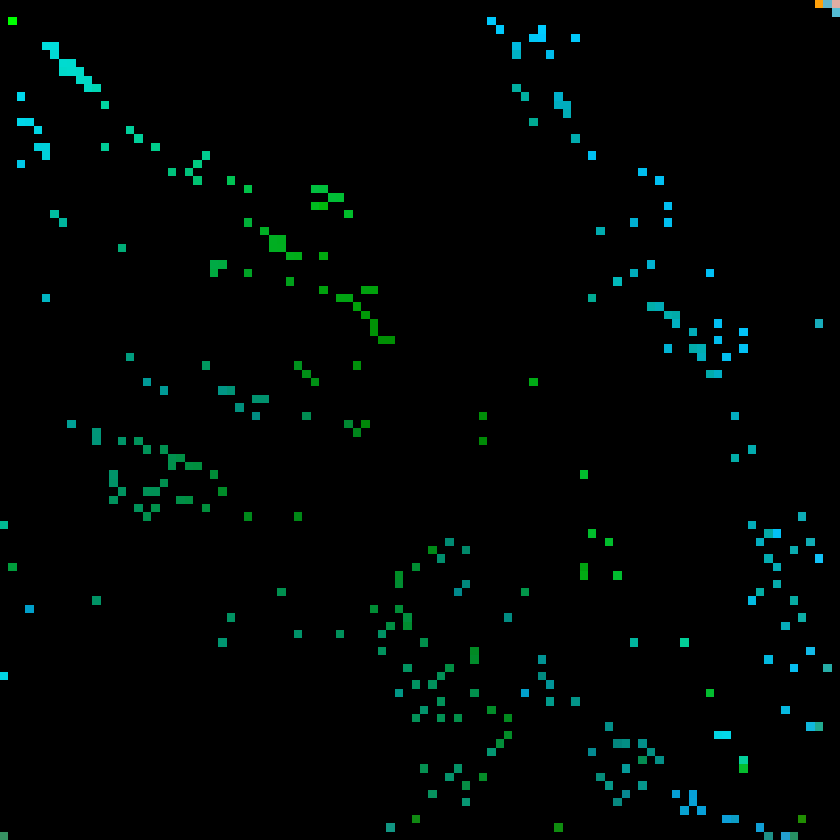

In [66]:
plot_img = function(m){
    require(grid)
    m = lapply(m, function(x) scales::rescale(x, to=c(0,1)))
    col = rgb(m[[1]], m[[2]], m[[3]])
    dim(col) = dim(m[[1]])
    grid.raster(col, interpolate=FALSE)
}
plot_img(res[[1]])

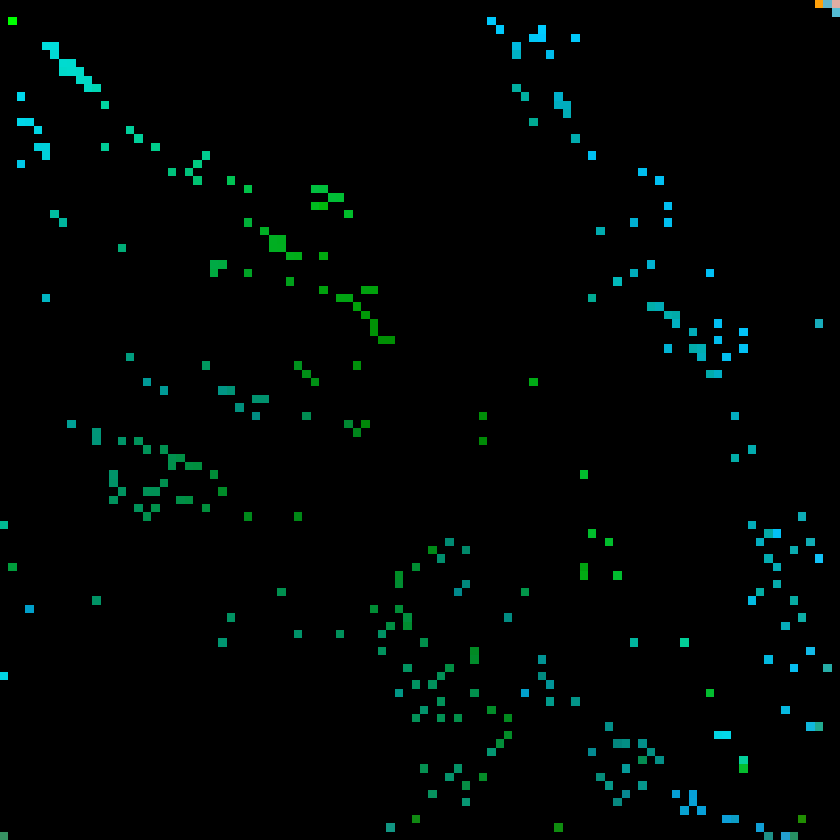

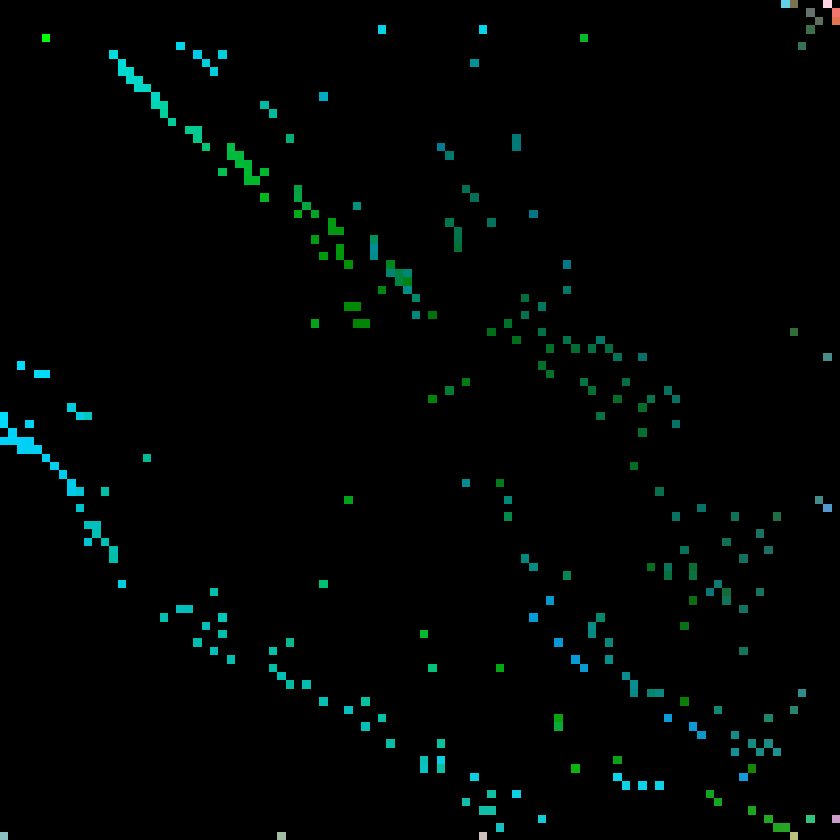

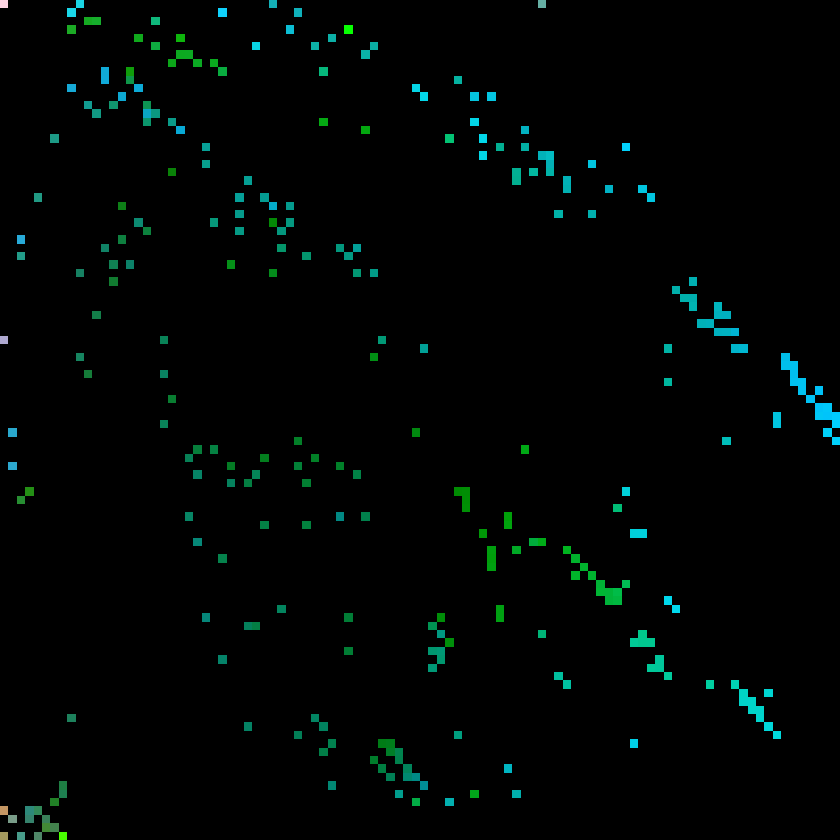

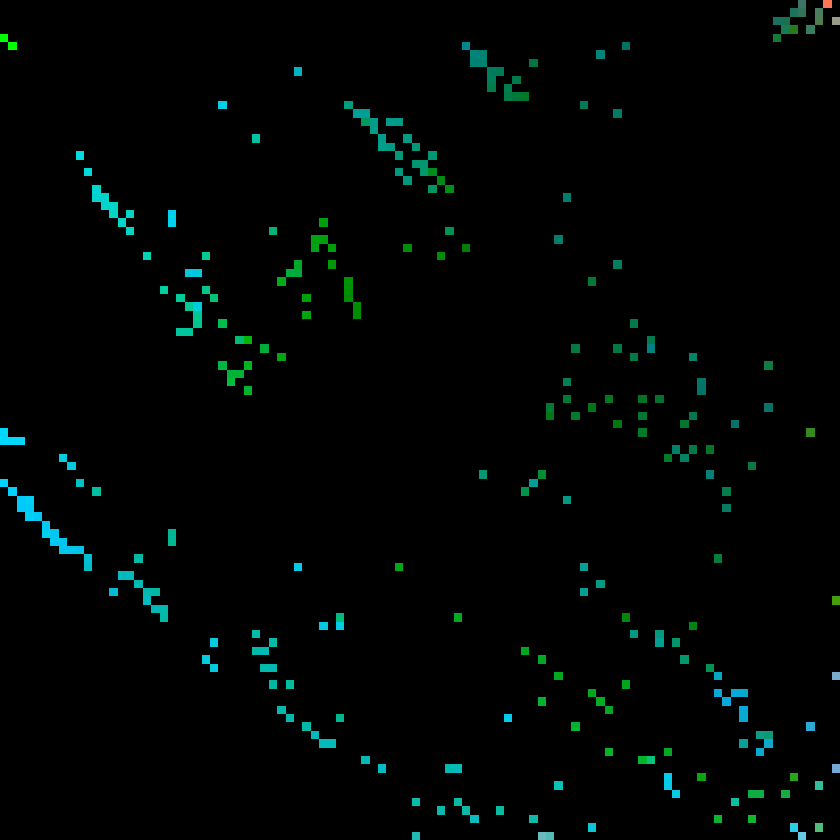

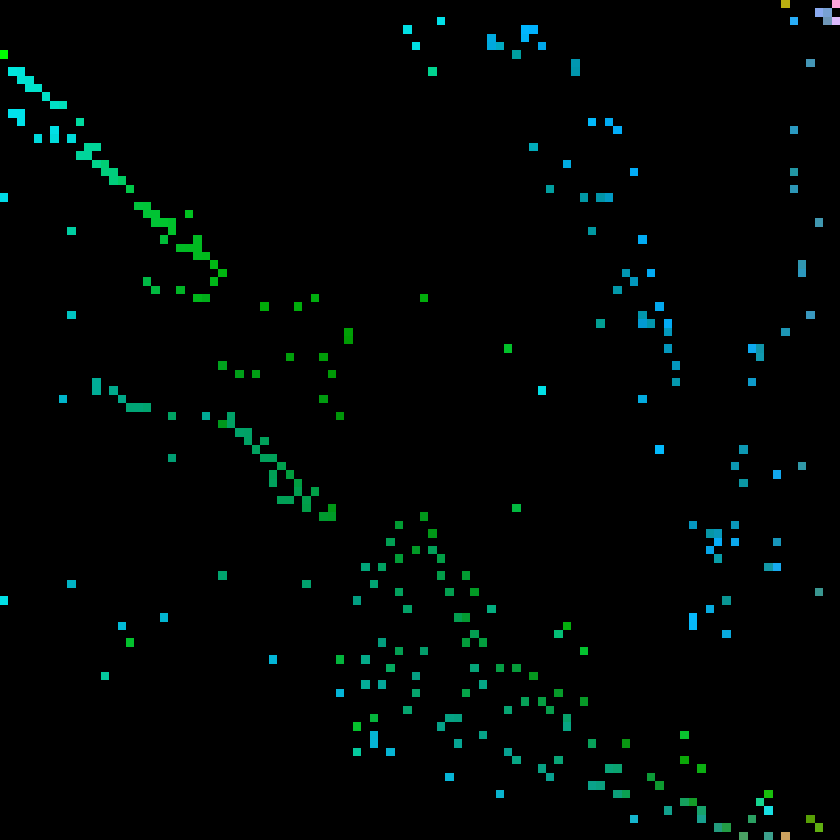

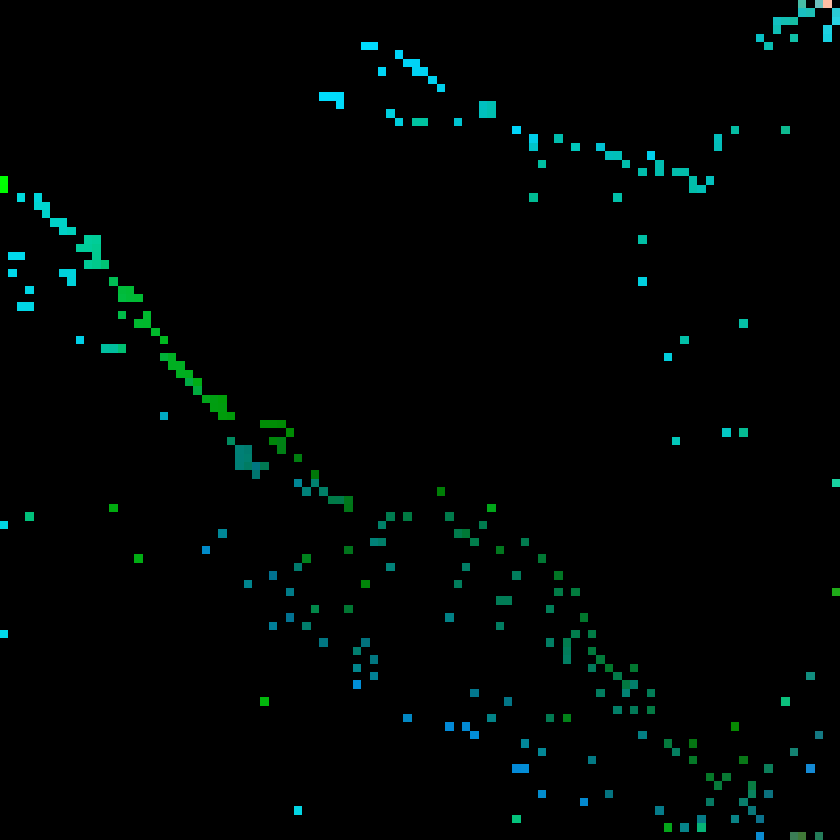

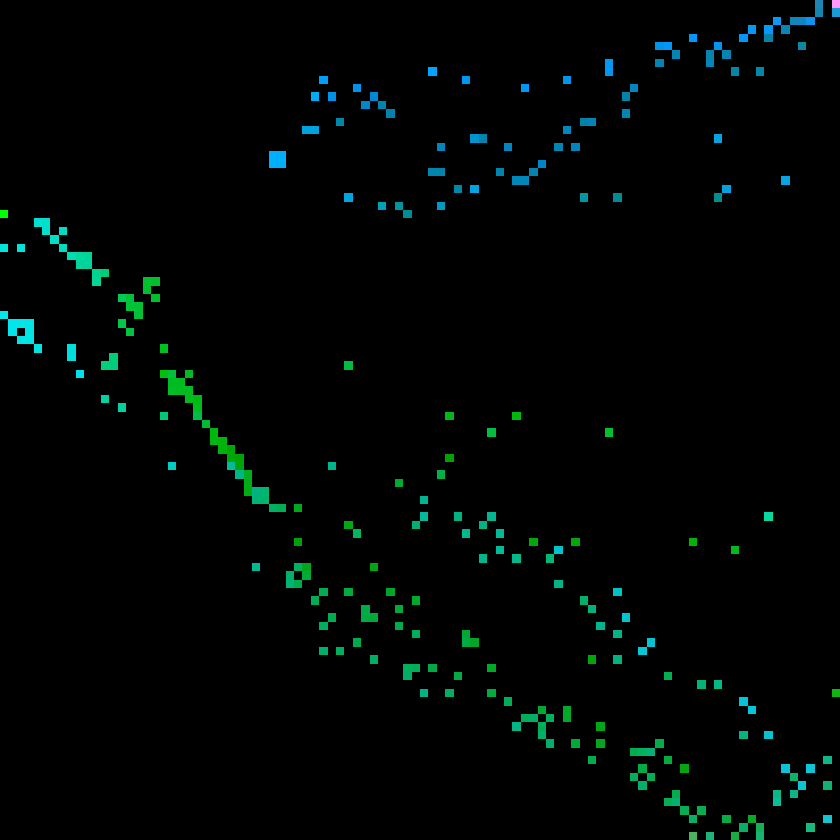

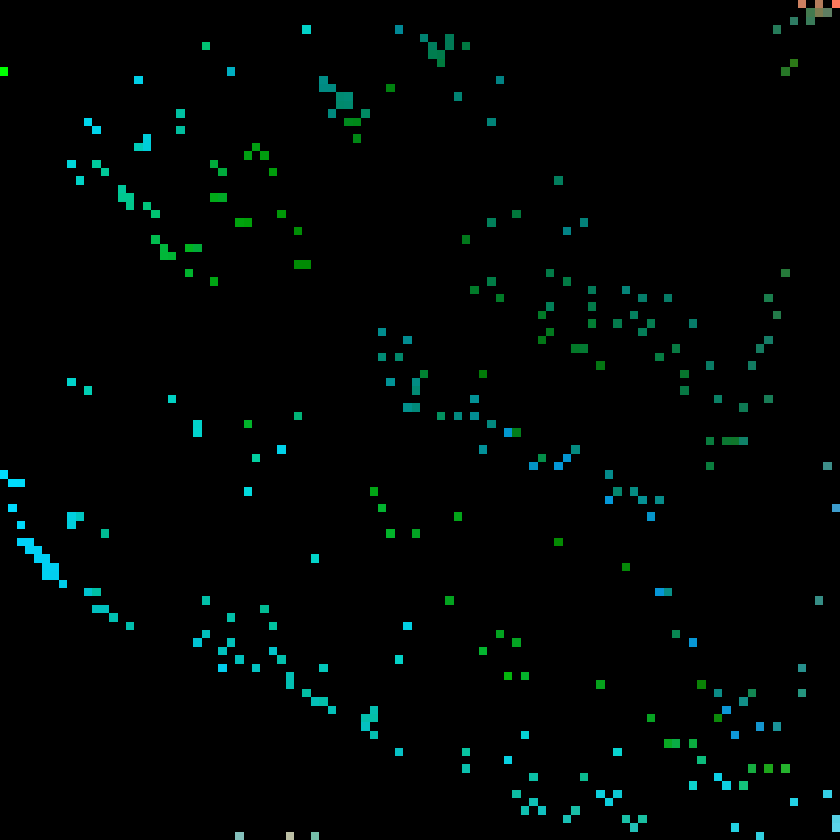

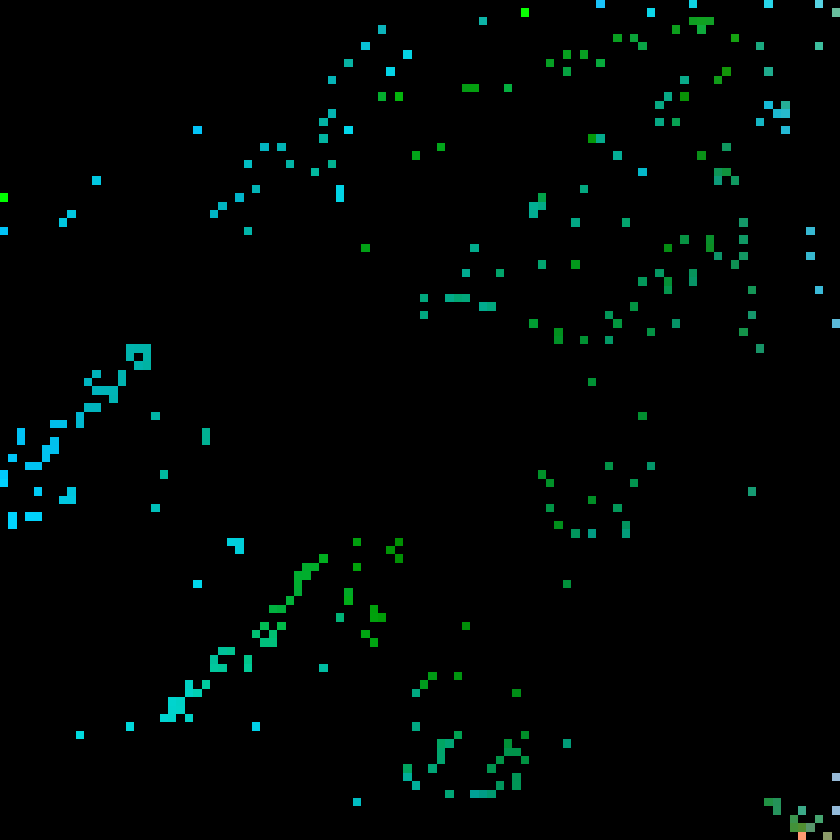

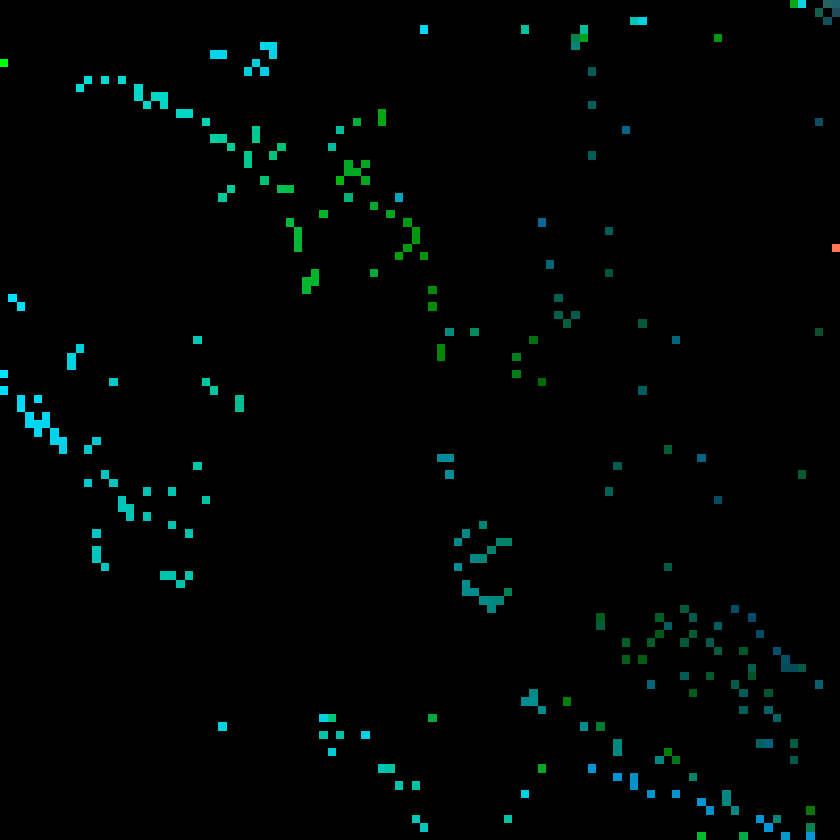

In [67]:
x = res %>% lapply(function(x) {plot_img(x); grid.newpage()})

## Running on westernized/non-westernized

In [68]:
west = meta %>%
    filter(Sample %in% rownames(m),
           westernized==TRUE) %>%
    sample_n(10) %>%
    .$Sample

nwest = meta %>%
    filter(Sample %in% rownames(m),
           westernized==FALSE) %>%
    sample_n(10) %>%
    .$Sample

west
nwest

[1] "YSZC12003_36533" "G88994"          "G88794"          "SAMEA104142083" 
 [5] "G88932"          "SAMEA104142092"  "YEZ_N.35"        "nHM511615"      
 [9] "AS51_12"         "DHAK_HDC"

[1] "A47_01_1FE"   "A70_01_1FE"   "A24_04_1FE"   "A58_01_1FE"   "M1.63.ST"    
 [6] "SRR3993057"   "SID030704"    "SID02A_561"   "CM_D24_M0_18" "A05_01_1FE"

In [69]:
# Running on westernized
y = 1:ncol(m)             
m_f = m[west,y]
mpd_res_f = mpd_res[rownames(m_f), colnames(m_f)]
mntd_res_f = mntd_res[rownames(m_f), colnames(m_f)]
res = make_imgs(m_f, mpd_res_f, mntd_res_f, phy, bins=20)
res %>% length

ERROR: Error in eval(expr, envir, enclos): object 'mntd_res' not found


In [ ]:
x = res %>% lapply(function(x) {plot_img(x); grid.newpage()})

In [41]:
# Running on non-western 
y = 1:ncol(m)             
m_f = m[nwest,y]
mpd_res_f = mpd_res[rownames(m_f), colnames(m_f)]
mntd_res_f = mntd_res[rownames(m_f), colnames(m_f)]
res = make_imgs(m_f, mpd_res_f, mntd_res_f, phy, bins=20)
res %>% length

ERROR: Error in eval(expr, envir, enclos): object 'mntd_res' not found


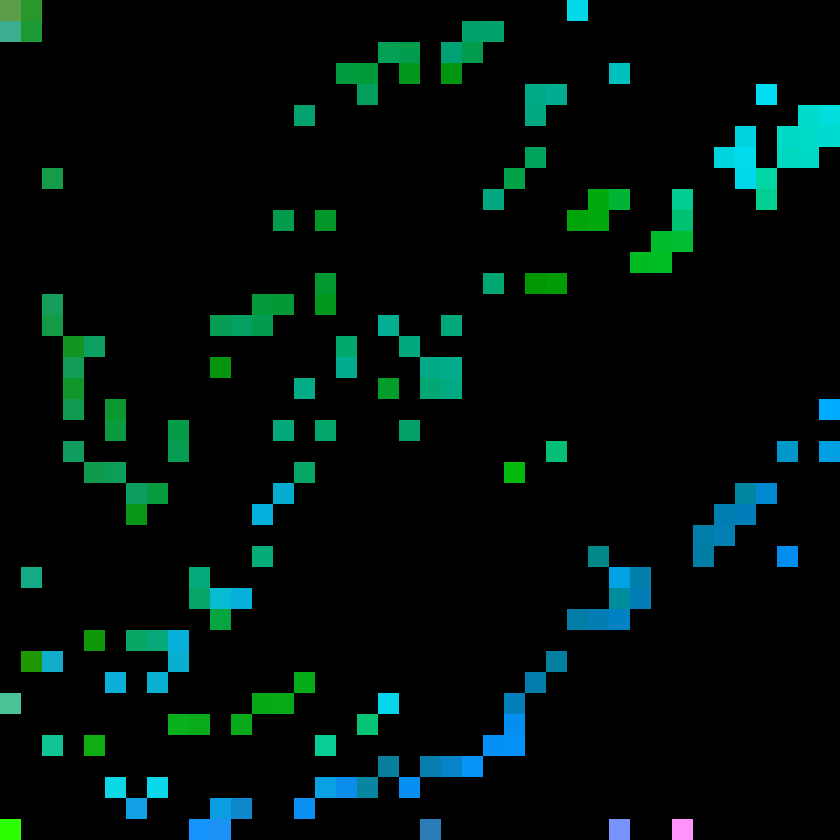

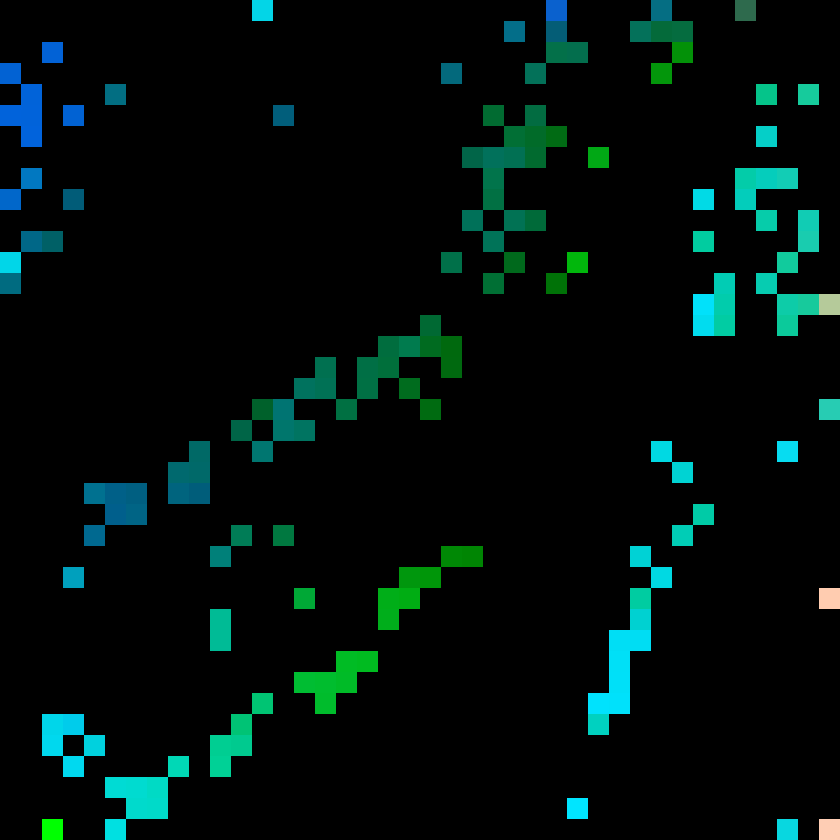

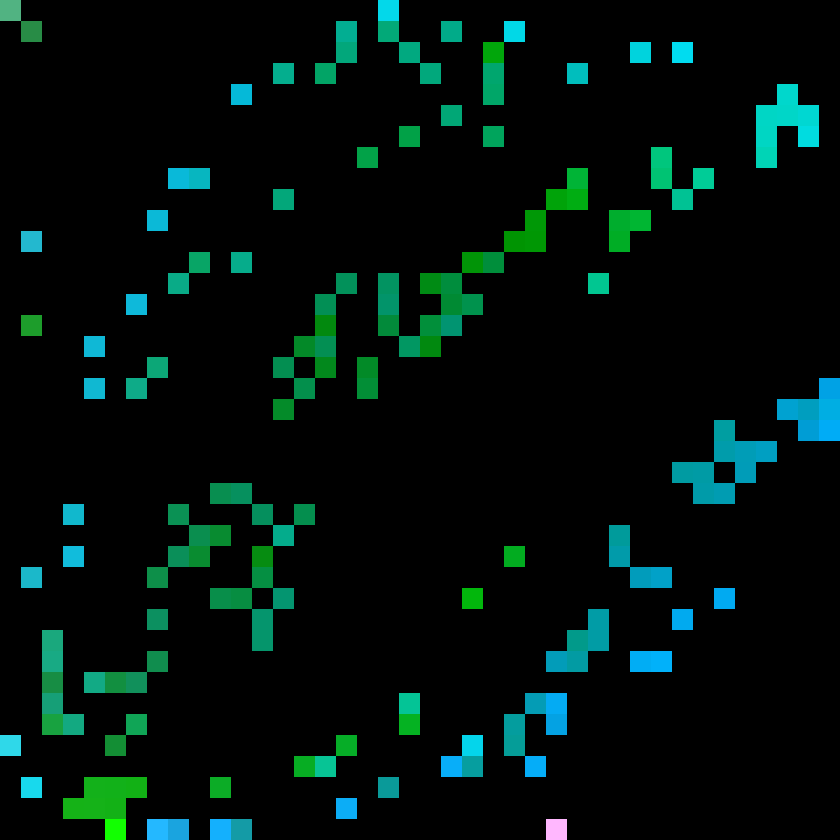

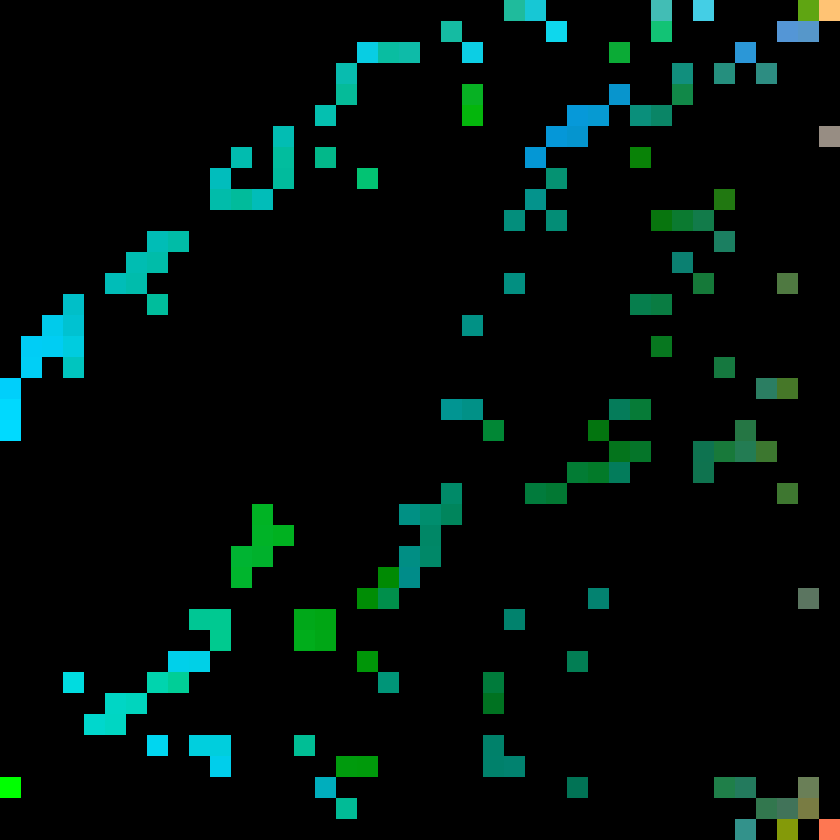

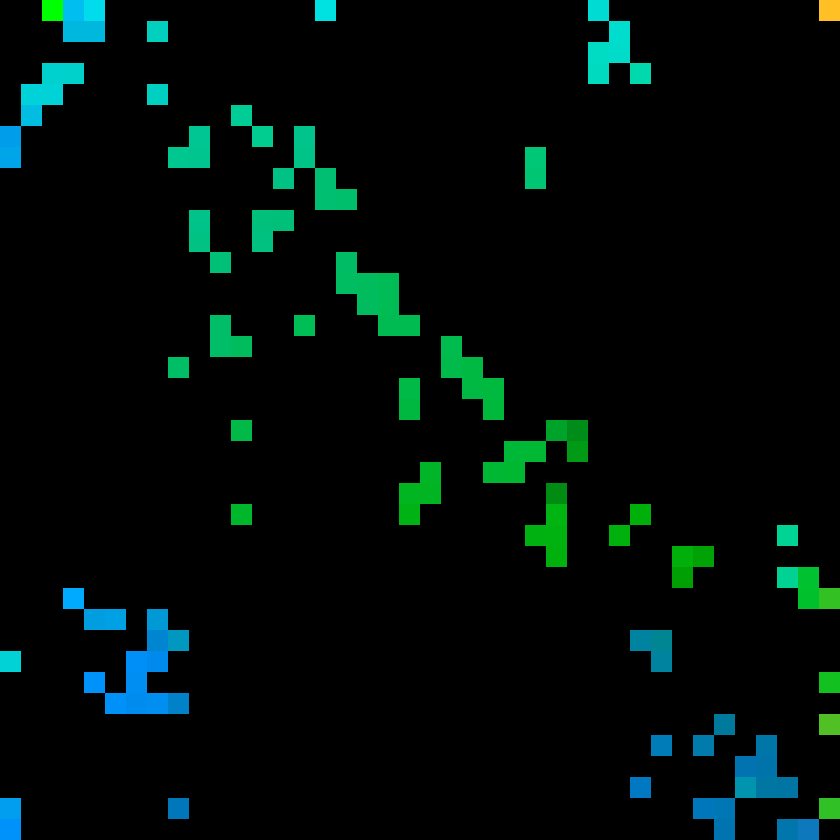

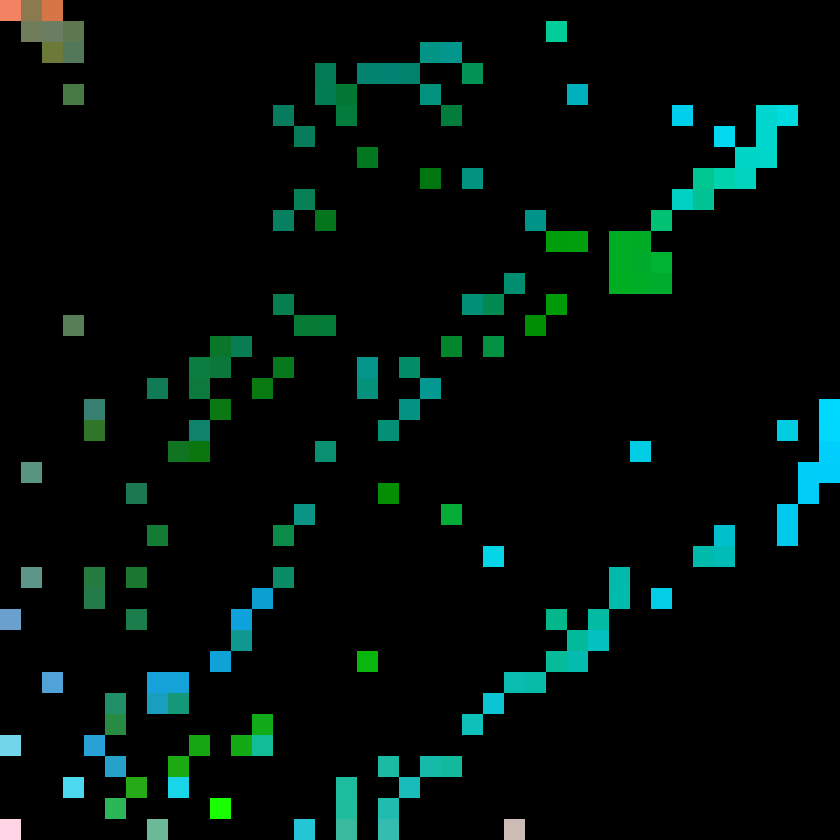

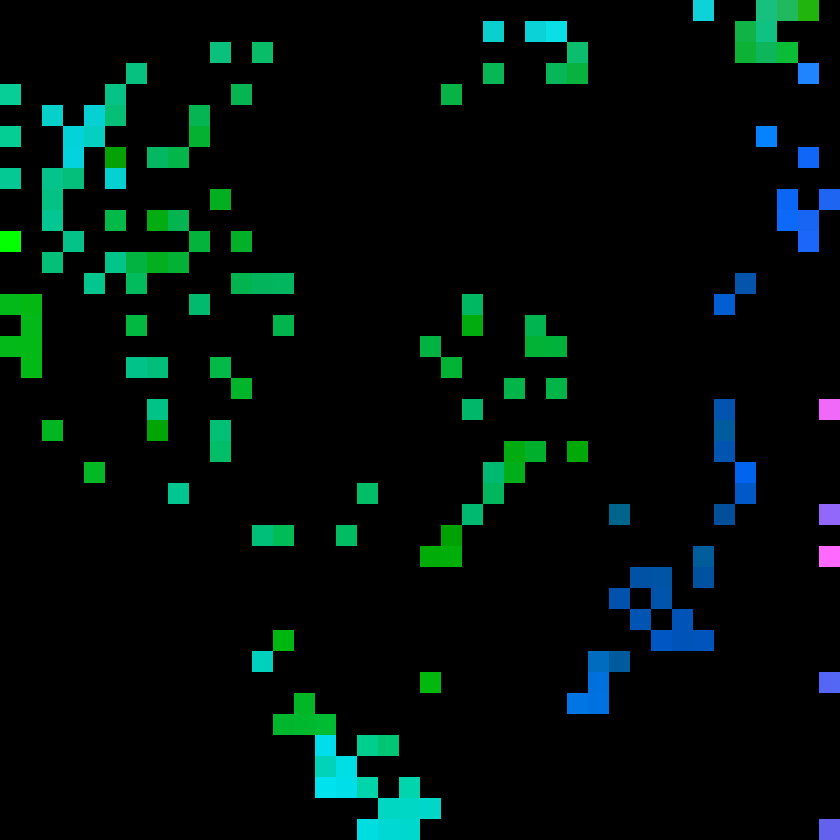

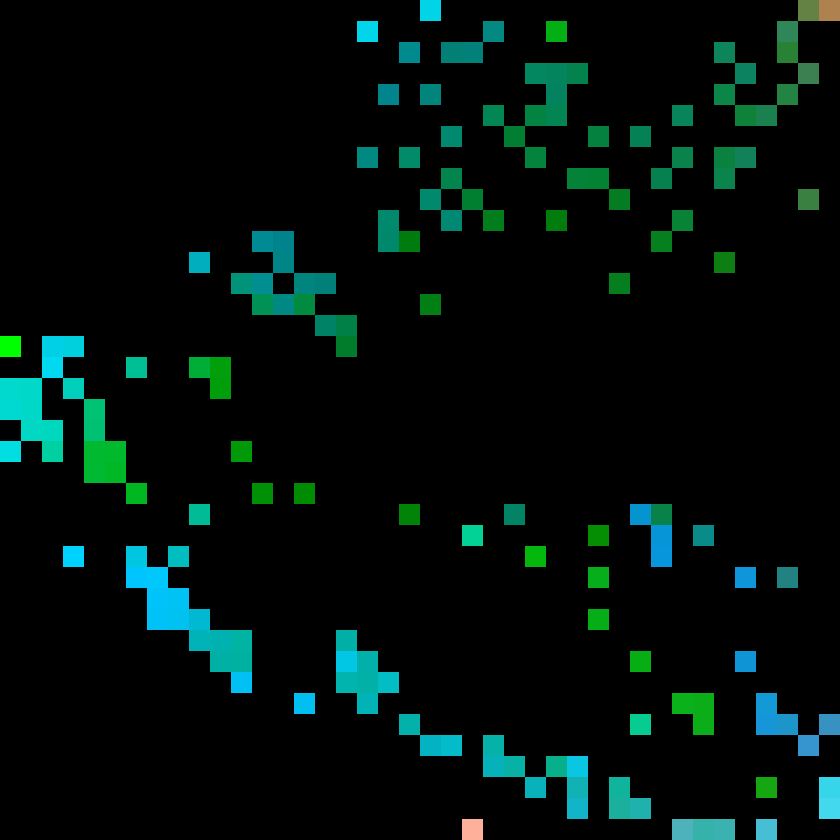

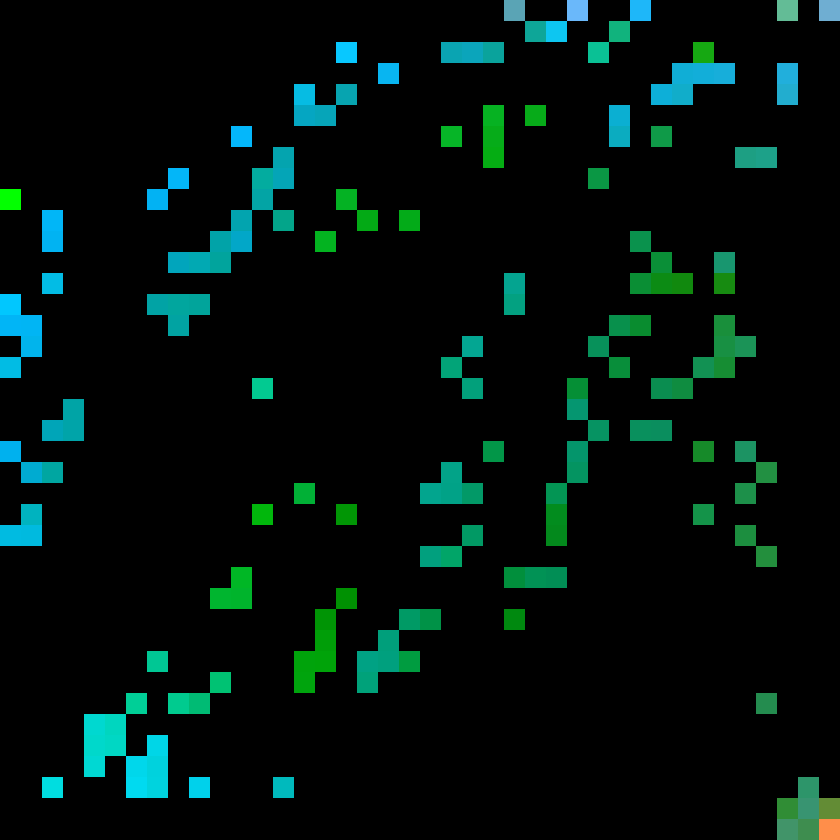

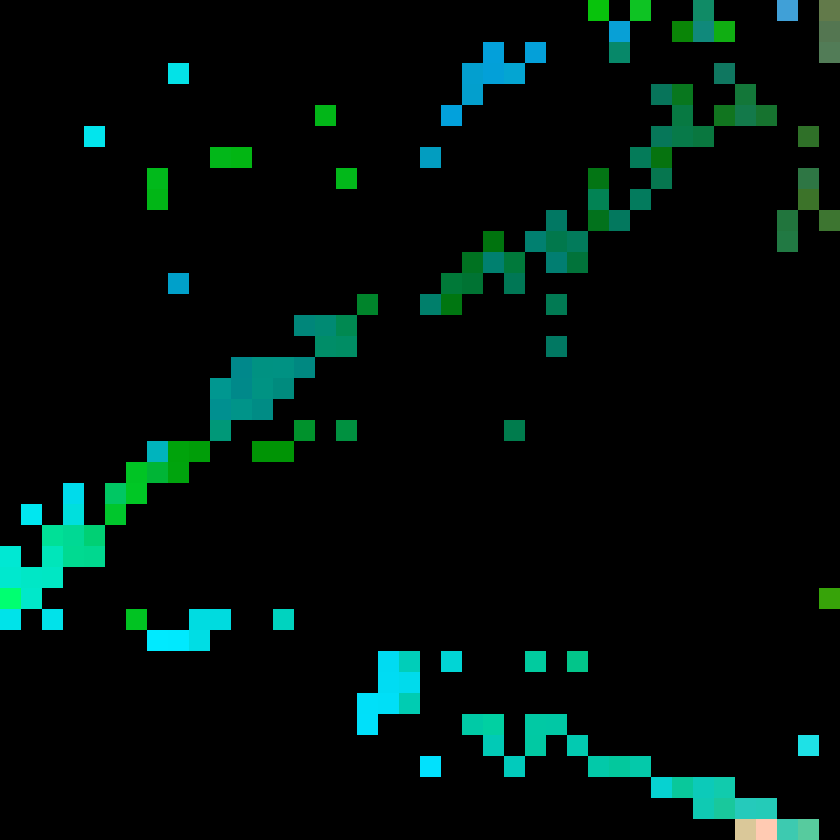

In [42]:
x = res %>% lapply(function(x) {plot_img(x); grid.newpage()})

### Notes

* Red
  * Abundant taxa
* Green 
  * Abundant taxa with high global phylogenetic uniqueness (MPD)
* Blue
  * Abundant taxa with local phylogenetic uniqueness (MNTD)

# Sandbox

In [118]:
x = rtree(10) %>% cophenetic
y = rtree(10) %>% cophenetic
x * y

,t6,t8,t10,t7,t3,t4,t2,t5,t9,t1
t6,0.000000,2.977194,2.8064490,10.63759,12.06245,15.62979,13.49957,8.916946,8.588363,6.125844
t8,2.977194,0.000000,0.1092142,11.56144,13.04029,16.72712,14.51704,9.767984,9.394830,6.810017
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
t9,8.588363,9.394830,9.283644,7.050793,8.151348,6.208584,4.890823,2.237504,0.000000,7.326415
t1,6.125844,6.810017,6.730427,9.853301,11.217338,13.902934,11.901865,7.603798,7.326415,0.000000


In [126]:
x * as.matrix(dist(1:10))

,t6,t8,t10,t7,t3,t4,t2,t5,t9,t1
t6,0.000000,1.470973,2.6476784,8.241850,11.947766,18.07304,20.62033,17.30646,25.41626,24.85851
t8,1.470973,0.000000,0.1721248,5.786565,9.398822,15.04243,17.91361,15.71011,23.26122,23.26444
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
t9,25.41626,23.26122,19.05538,15.56208,13.4083,6.854252,4.213731,1.118751,0.00000,2.94937
t1,24.85851,23.26444,19.32645,16.18465,14.6855,13.547783,9.627183,4.489381,2.94937,0.00000


In [348]:
x = 9
y = 9
m = matrix(runif(x * y), nrow=x, ncol=y)
#m = array(list(m, m, m))
m

0.7040237,0.4338994,0.2429822,0.2099479,0.3327092,0.37054632,0.6681803,0.0278478,0.18052362
0.8920783,0.6843122,0.6581343,0.2701347,0.7698221,0.04657817,0.8070608,0.7465684,0.05901798
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.2889646,0.7086677,0.6654332,0.6530532,0.5231469,0.02836341,0.8224359,0.6404304,0.7377723
0.3567245,0.9921423,0.9131994,0.4904457,0.9269433,0.81568428,0.5820559,0.2124015,0.3850172


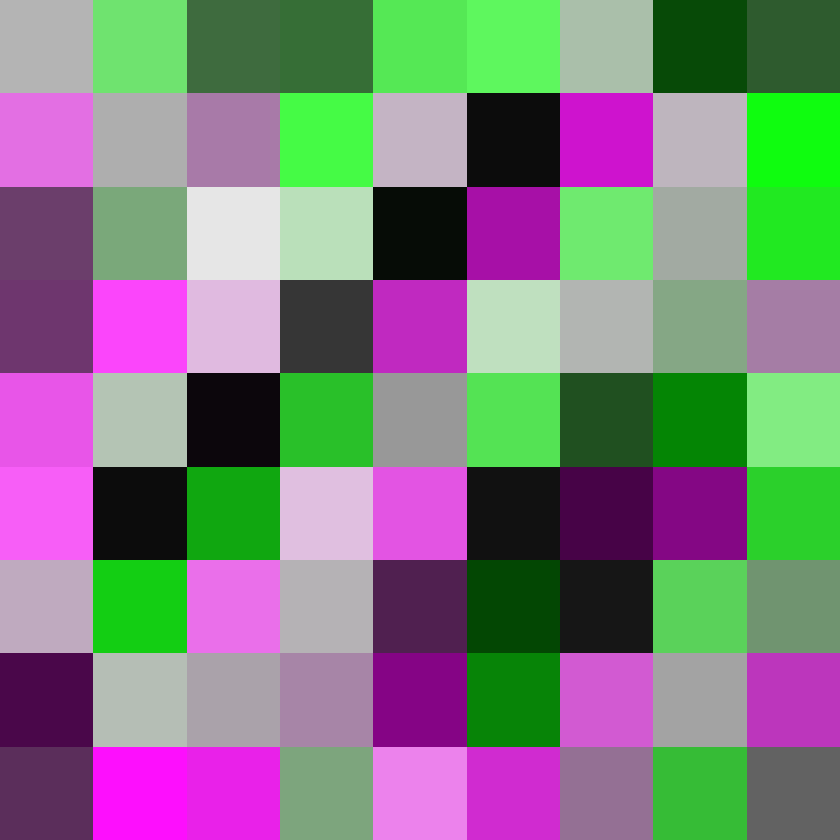

In [356]:
col = rgb(m, t(m), m)
dim(col) = dim(m)

library(grid)
grid.raster(col, interpolate=FALSE)